## Introduction to Pairs Trading

Pairs trading is a statistical arbitrage strategy to exploit pricing inefficiencies between related financial instruments. The strategy involves identifying pairs of assets, such as stocks within the same sector, an exchange-traded fund (ETF) and its underlying constituents, or futures contracts and their corresponding spot prices. These instruments typically exhibit a long-term equilibrium relationship but can deviate in the short term due to market inefficiencies. 

The core idea behind pairs trading is to capitalize on these temporary deviations by going long on the underperforming asset (expecting it to rise) and shorting the outperforming one (expecting it to fall). When the price spread between the two assets returns to its historical average, the trader closes both positions, securing a profit from the convergence. 

Pairs trading is a market-neutral strategy, meaning it can be profitable regardless of overall market direction, as it focuses on the relative performance of the paired assets. This method is widely used across asset classes, including stocks, ETFs, futures, and commodities, making it a versatile tool for traders looking to profit from short-term mispricings in correlated financial instruments.

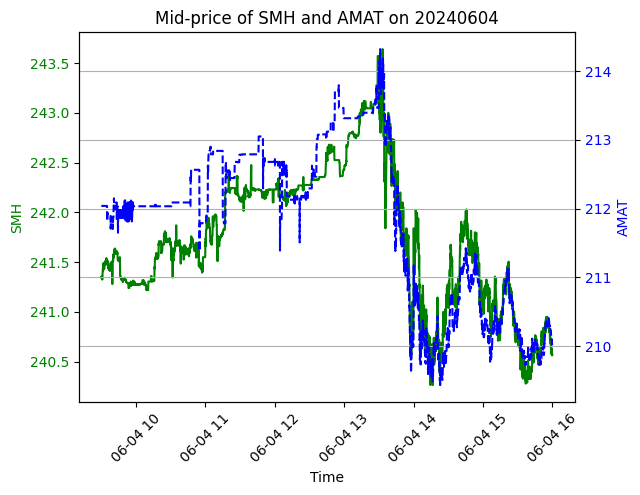

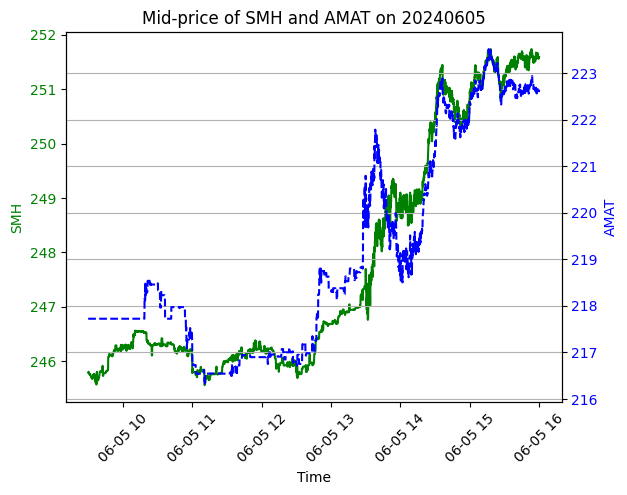

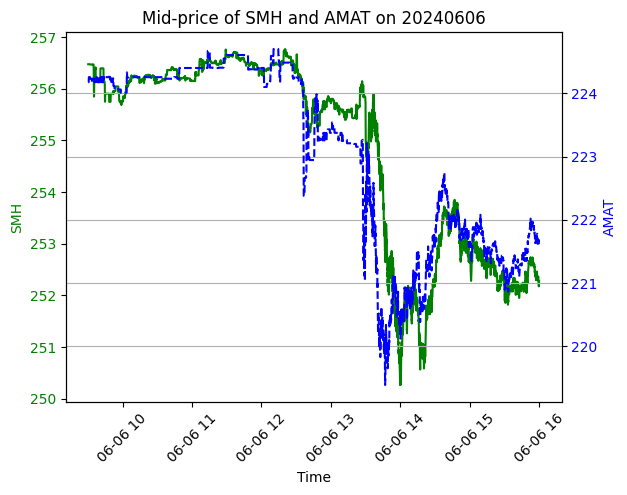

In [1]:
## Illustrate cointegration of SMH and AMAT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_quote_data(symbol: str, date: str) -> pd.DataFrame:
    csv_name = f"{symbol}_{date}_quote.csv"
    quote_data = pd.read_csv(f"data/{csv_name}", sep=",")
    
    # Convert timestamp to datetime, handling potential errors
    try:
        quote_data['timestamp'] = pd.to_datetime(quote_data['timestamp']) 
    except ValueError as e:
        print(f"Error parsing timestamps for {symbol}: {e}")
        # Optionally use coerce to handle this
        quote_data['timestamp'] = pd.to_datetime(quote_data['timestamp'], errors='coerce')
    
    quote_data.set_index('timestamp', inplace=True)
    return quote_data

def calculate_midprice_and_downsample(quote_data : pd.DataFrame , downsample : int) -> pd.Series:
    quote_data["mid_price"] = np.where(
        (quote_data["ask_price"] > 0) & (quote_data["bid_price"] > 0),
        (quote_data["ask_price"] + quote_data["bid_price"]) * 0.5,
        np.nan
    )
    downsampled_mid_price = quote_data["mid_price"].resample(f'{downsample}S').last()
    downsampled_mid_price = downsampled_mid_price.fillna(method='ffill')
    #print(type(downsampled_mid_price))
    return downsampled_mid_price

symbols = ["SMH", "AMAT"]
dates = ["20240604","20240605","20240606"]
downsample = 5 ## resample mid-price every 5s

for date in dates:

    df_midprice = pd.DataFrame()
    for symbol in symbols:
        quote_data_by_symbol = load_quote_data(symbol= symbol, date=date)
        downsampled_mid_price_by_symbol = calculate_midprice_and_downsample(quote_data = quote_data_by_symbol, downsample = downsample)
        df_midprice[symbol] = downsampled_mid_price_by_symbol
        df_midprice = df_midprice.fillna(method='ffill')
        df_midprice = df_midprice.fillna(method='bfill')

    fig, ax1 = plt.subplots()

    asset1 = "SMH"
    asset2 = "AMAT"

    ax1.plot(df_midprice[f"{asset1}"], 'g-')  
    ax1.set_xlabel('Time')
    ax1.set_ylabel(f'{asset1}', color='g')
    ax1.tick_params(axis='y', labelcolor='g')

    plt.xticks(rotation=45)

    ax2 = ax1.twinx()
    ax2.plot(df_midprice[f"{asset2}"], 'b--')  
    ax2.set_ylabel(f'{asset2}', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    # Optionally set a title
    plt.title(f'Mid-price of {asset1} and {asset2} on {date}')

    # Show the plot
    plt.grid()
    plt.show();

SMH is an ETF that represents the semiconductor sector, while AMAT is a semiconductor stock. The plot above shows the intraday mid-price movements of SMH and AMAT, and it is evident that both assets tend to move in tandem. This suggests that there may be a long-term equilibrium relationship between the two assets, likely due to their similar exposure to the semiconductor industry.

Although short-term deviations between the prices of SMH and AMAT can be observed, the overall pattern suggests that the prices are closely related. These short-term price deviations present potential opportunities for pairs trading, where one asset can be bought and the other sold when their price spread deviates from the historical relationship, with the expectation that the prices will eventually revert to the equilibrium.

### Cointegration Test

While the plots suggest that SMH and AMAT may be cointegrated, it is important to statistically confirm this relationship. One way to do this is by performing a cointegration test. There are two common approaches to test for cointegration: the **Engle-Granger two-step method (EG method)** and the **Johansen test**. These tests help determine if a linear combination of two or more non-stationary time series moves together over time, which is a key assumption for pairs trading strategies.

For this introduction, we will use the **Engle-Granger method**. The EG method consists of two steps:

1. **Step 1**: Perform a linear regression on the mid-prices of SMH and AMAT to determine the relationship between the two assets. This regression provides a hedge ratio, which determines how many units of SMH are needed for each position in AMAT.
   
2. **Step 2**: Test the residuals from the linear regression to check for stationarity using the **Augmented Dickey-Fuller (ADF) test**. If the residuals are stationary, it suggests that the two assets are cointegrated, meaning their prices will revert to a long-term equilibrium despite short-term deviations.

The linear relationship between SMH and AMAT can be expressed as:

$$
S_t^{\text{AMAT}} = \text{hedge\_ratio} \times S_t^{\text{SMH}} + \text{Constant} + \epsilon_t
$$

where

-  $ S_t^{\text{AMAT}} $  is the price of AMAT at time  $ t $ .
-   $S_t^{\text{SMH}} $  is the price of SMH at time  $ t $ .
- $ \epsilon_t $  represents the residuals or deviations from the equilibrium relationship.
- The **hedge ratio** is the slope of the linear regression and indicates how much of SMH is required to hedge a position in AMAT.

If the ADF test confirms that the residuals ( $ \epsilon_t $ ) are stationary (p-value < 0.05), we can conclude that SMH and AMAT are cointegrated. This forms the basis for a pairs trading strategy, where price deviations between the two assets present potential profit opportunities as they revert to their equilibrium. 

In [2]:
import statsmodels.api as sm 
from typing import Optional , Tuple

def calculate_half_life(spread : np.ndarray) -> float:
    # Ensure spread is a Pandas Series for easy manipulation
    df_spread = pd.DataFrame(spread, columns=["spread"])
    
    # Calculate lagged spread and spread returns
    spread_lag = df_spread.spread.shift(1).fillna(method="bfill")  # Backfill the first NaN
    spread_ret = df_spread.spread - spread_lag

    # Add a constant to the lagged spread
    spread_lag2 = sm.add_constant(spread_lag)
    
    # Fit the OLS model
    model = sm.OLS(spread_ret, spread_lag2)
    res = model.fit()

    # Calculate the half-life
    halflife = -np.log(2) / res.params[1]
    
    return round(halflife, 0)

def cointegration_check_weighted(price_data: pd.DataFrame, asset1: str, asset2: str) -> Tuple[bool, Optional[dict]]:
    
    res_mean = 0 
    res_std = 0
    rsquared_adj = 0
    const = 0
    hedge_ratio = 0 
    half_life = 0
    p_value_adf_test = 0
    adjustment_coefficient = 0
    length = len(price_data)

    
    price_data["date"] = price_data.index.date
    unique_date = price_data["date"].unique()

    for date in unique_date:

        price_data_by_date = price_data[price_data.date == date]
        weight = len(price_data_by_date) / length
    
        # Step 1: Perform OLS regression
        model1 = sm.OLS(price_data_by_date[asset2], sm.add_constant(price_data_by_date[asset1])).fit()
        res_by_date = model1.resid  # Note the change to model1.resid

        # Calculate the mean and std of the residual
        res_mean_by_date = np.mean(res_by_date)
        res_std_by_date= np.std(res_by_date)
        rsquared_adj_by_date = model1.rsquared_adj
        const_by_date = model1.params[0]
        hedge_ratio_by_date = model1.params[1]
        half_life_by_date = calculate_half_life(np.array(res_by_date))   

        # Step 2: ADF test on residuals
        adf_test_result_by_date = sm.tsa.stattools.adfuller(res_by_date)
        p_value_adf_test_by_date = adf_test_result_by_date[1]   

        # Step 3: Error Correction Model (ECM)
        # Include lagged residuals and the difference of asset1 as regressors
        asset1_diff = sm.add_constant(pd.concat([price_data_by_date[asset1].diff(), res_by_date.shift(1)], axis=1).dropna())
        asset2_diff = price_data_by_date[asset2].diff().dropna()

        # Aligning asset1_diff and asset2_diff to ensure they have the same length

        asset1_diff = asset1_diff.loc[asset2_diff.index]
        model2 = sm.OLS(asset2_diff, asset1_diff).fit()

        # Step 4: Check if the adjustment coefficient is negative
        adjustment_coefficient_by_date = list(model2.params)[-1]

        res_mean += res_mean_by_date * weight 
        res_std += res_std_by_date * weight 
        rsquared_adj += rsquared_adj_by_date * weight
        const += const_by_date * weight
        hedge_ratio += hedge_ratio_by_date * weight
        half_life += half_life_by_date * weight

        p_value_adf_test = max(p_value_adf_test_by_date, p_value_adf_test)
        adjustment_coefficient += adjustment_coefficient_by_date * weight

    coint_result = {"asset 1": asset1,
                    "asset 2": asset2,
                    "res mean":res_mean ,
                    "res std":res_std,
                    "adj rsquared": rsquared_adj,
                    "constant" : const,
                    "hedge ratio": hedge_ratio,
                    "half life": half_life,
                    "p-value of adf test" : p_value_adf_test,
                    "adjustment coef":adjustment_coefficient}
    if (p_value_adf_test < 0.05 ) and (adjustment_coefficient < 0):
        return True, coint_result
    else:
        return False, None
    
symbols = ["SMH", "AMAT"]
dates = ["20240604","20240605"]
downsample = 5 ## resample mid-price every 5s

df_midprice = pd.DataFrame({})
for date in dates:
    df_midprice_by_day = pd.DataFrame()
    for symbol in symbols:
        quote_data_by_symbol = load_quote_data(symbol= symbol, date=date)
        downsampled_mid_price_by_symbol = calculate_midprice_and_downsample(quote_data = quote_data_by_symbol, downsample = downsample)
        df_midprice_by_day[symbol] = downsampled_mid_price_by_symbol
    df_midprice = pd.concat([df_midprice, df_midprice_by_day])
df_midprice = df_midprice.fillna(method='ffill')
df_midprice = df_midprice.fillna(method='bfill')

coint_result = cointegration_check_weighted(df_midprice, "SMH", "AMAT") 
p_value = coint_result[1]["p-value of adf test"]
hedge_ratio = coint_result[1]["hedge ratio"]
constant = coint_result[1]["constant"]
half_life = coint_result[1]["half life"] * downsample / 60
if coint_result[0]:
    print(f"{symbols[0]} and {symbols[1]} are co-integrated")
    print(f"p-value of adf test is {p_value}")
    print(f"Hedge ratio is {hedge_ratio}")
    print(f"Constant is {constant}")
    print(f"Half life is {half_life} mins")
else:
    print(f"{symbols[0]} and {symbols[1]} are not co-integrated")

SMH and AMAT are co-integrated
p-value of adf test is 0.003079974671677564
Hedge ratio is 1.2739065281301585
Constant is -95.67751733651085
Half life is 4.833333333333333 mins


By applying the Engle-Granger (EG) method to the mid-price data from 2024-06-04 and 2024-06-05, we find that SMH and AMAT are co-integrated, with the following key parameters:

- p-value of ADF test: 0.0031 (confirming stationarity of the residuals)
- Hedge ratio: 1.274
- Constant: -95.7
- Half-life of mean reversion: 4.83 minutes

Since the data includes discontinuities (due to periods outside of market hours), we have weighted the parameters based on the number of data points available for each day. We will now use these parameters for signal generation on 2024-06-06, which is our trading day. The hedge ratio and constant will be applied to monitor deviations in the price spread between SMH and AMAT, allowing us to identify potential trading opportunities as the spread reverts to its equilibrium. 

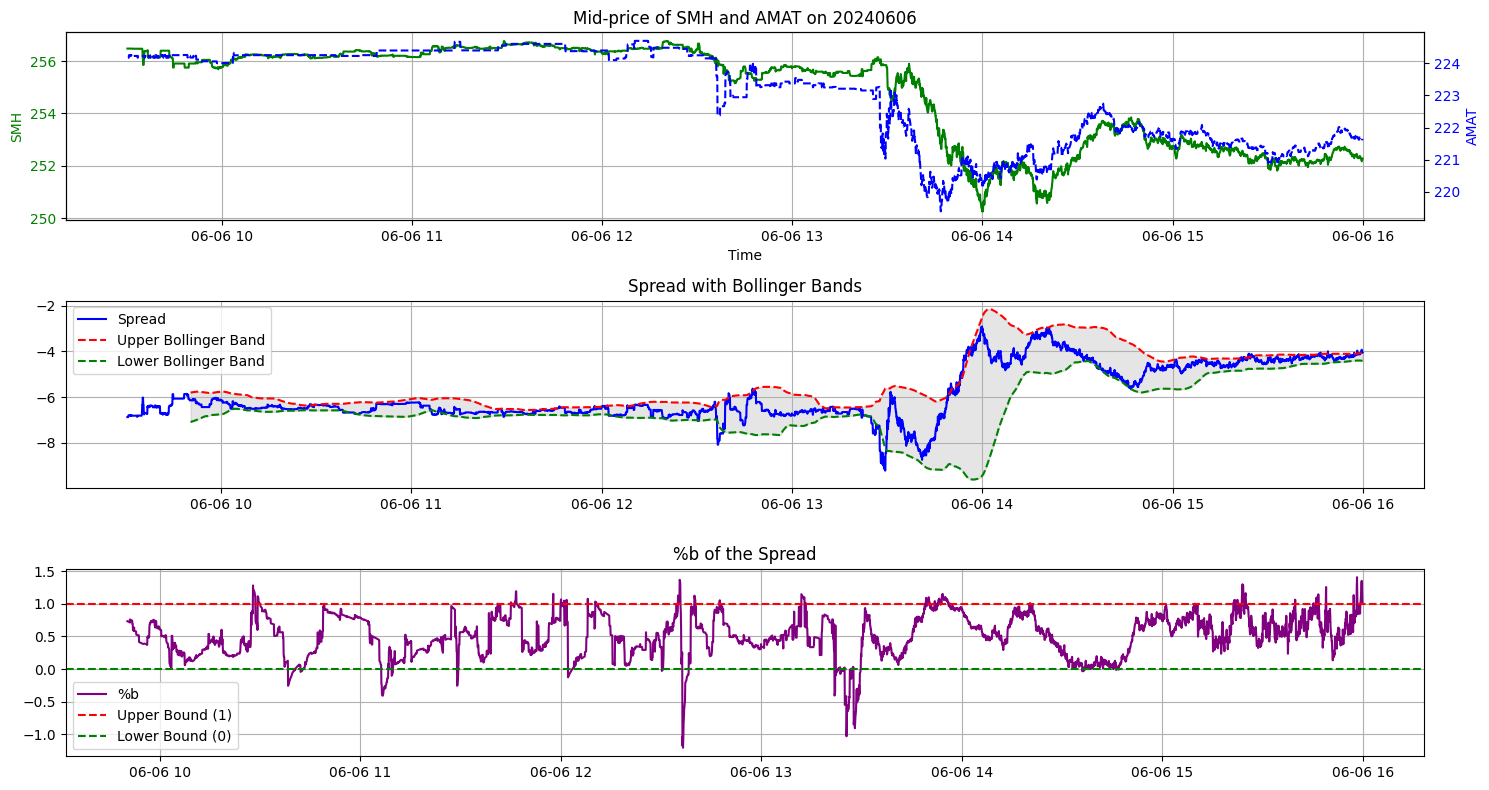

In [3]:
symbols = ["SMH", "AMAT"]
date = "20240606"
downsample = 5 ## resample mid-price every 5s
period = 240
k = 2

df_midprice = pd.DataFrame({})
for symbol in symbols:
    quote_data_by_symbol = load_quote_data(symbol= symbol, date=date)
    downsampled_mid_price_by_symbol = calculate_midprice_and_downsample(quote_data = quote_data_by_symbol, downsample = downsample)
    df_midprice[symbol] = downsampled_mid_price_by_symbol
spread = df_midprice[symbols[1]] - hedge_ratio * df_midprice[symbols[0]] - constant
spread_rolling_mean = spread.rolling(period).mean()
spread_rolling_std = spread.rolling(period).std()
upper_band = spread_rolling_mean + k * spread_rolling_std
lower_band = spread_rolling_mean - k * spread_rolling_std
pertb = (spread - lower_band) / (upper_band - lower_band)
z_score = (spread -spread_rolling_mean ) / spread_rolling_mean


# Create a 3-row, 1-column grid of subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 8))

# Plot 1: Mid-price of symbols[0] and symbols[1] with twin axes
ax1 = axes[0]
ax1.plot(df_midprice[f"{symbols[0]}"], 'g-')  
ax1.set_xlabel('Time')
ax1.set_ylabel(f'{symbols[0]}', color='g')
ax1.tick_params(axis='y', labelcolor='g')
#ax1.tick_params(axis='x', rotation=45)
ax3 = ax1.twinx()
ax3.plot(df_midprice[f"{symbols[1]}"], 'b--')  
ax3.set_ylabel(f'{symbols[1]}', color='b')
ax3.tick_params(axis='y', labelcolor='b')
ax1.grid()
ax1.set_title(f'Mid-price of {symbols[0]} and {symbols[1]} on {date}')

# Plot 2: Spread with Bollinger Bands
ax2 = axes[1]
ax2.plot(spread, label='Spread', color='blue')
ax2.plot(upper_band, label='Upper Bollinger Band', color='red', linestyle='--')
ax2.plot(lower_band, label='Lower Bollinger Band', color='green', linestyle='--')
ax2.fill_between(spread.index, lower_band, upper_band, color='gray', alpha=0.2)
ax2.set_title('Spread with Bollinger Bands')
ax2.legend()
ax2.grid()

# Plot 3: Percentage b (%b)
ax3 = axes[2]
ax3.plot(pertb, label='%b', color='purple')
ax3.axhline(1, color='red', linestyle='--', label='Upper Bound (1)')
ax3.axhline(0, color='green', linestyle='--', label='Lower Bound (0)')
ax3.set_title('%b of the Spread')
ax3.legend()
ax3.grid()

# Adjust layout
plt.tight_layout()
plt.show()

### Trading Signal Generation

To generate trading signals for our pairs trading strategy, we can calculate the %b from the Bollinger Bands of the spread (residual). The %b measures how far the current spread deviates from its equilibrium relative to the Bollinger Bands.

The strategy works as follows:

1. **Short the spread**: When %b reaches the lower band (i.e., the spread is significantly below its equilibrium), we go short on the spread. This involves shorting the linear combination of SMH and AMAT based on the hedge ratio.
   
2. **Long the spread**: When %b reaches the upper band (i.e., the spread is significantly above its equilibrium), we go long on the spread. This involves buying the linear combination of SMH and AMAT.

3. **Close the position**: When %b reaches 0.5 (i.e., the spread reverts back to its equilibrium), we close any open positions.

By adjusting the value of \( k \) (the number of standard deviations used to calculate the Bollinger Bands), we can modify the sensitivity of the trading signals. Larger values of \( k \) will result in fewer signals but may capture larger deviations, while smaller values of \( k \) will generate more frequent trading opportunities but may capture smaller, less significant deviations.

The following steps summarize the signal generation logic:
- **Short the spread**: %b < 0 (lower band)
- **Long the spread**: %b > 1 (upper band)
- **Close the position**: %b = 0.5 (mean reversion)

By adjusting the thresholds (k) for entering and exiting positions, this strategy aims to profit from the mean-reverting behavior of the spread between SMH and AMAT.

daily return SMH-AMAT pair is 3.571310768651448 %


Text(0.5, 1.0, 'Equity Curve of Backtest')

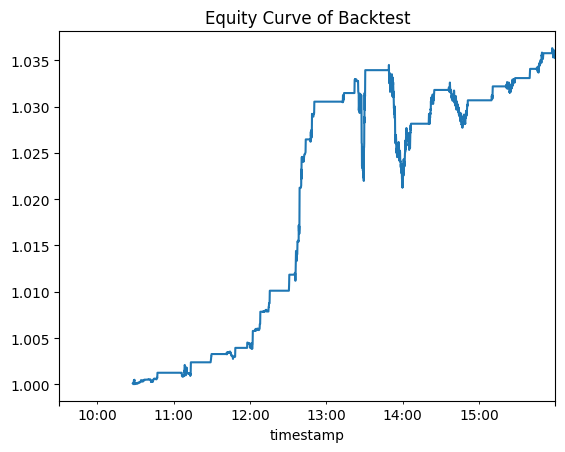

In [4]:
k = 2 # threshold

df_backtest = pd.DataFrame()
df_backtest["asset1"] = df_midprice[symbols[0]]
df_backtest["asset2"] = df_midprice[symbols[1]]
spread = df_backtest["asset2"] - ( hedge_ratio * df_backtest["asset1"] + constant)
df_backtest["residual"] = spread

# Calculate the rolling mean and standard deviation
residual_rolling_mean = spread.rolling(period).mean()
residual_rolling_std = spread.rolling(period).std()

# Calculate the Bollinger Bands
lower_band = spread_rolling_mean - k * spread_rolling_std
upper_band = spread_rolling_mean + k * spread_rolling_std

# Calculate %B

df_backtest["pert_b"] = (spread - lower_band) / (upper_band - lower_band)

df_backtest["signal1"] = np.nan
df_backtest["signal2"] =  np.nan

df_backtest.reset_index(inplace=True)
# Generate trading signals
position = 0  # 1 for long, -1 for short, 0 for neutral

for h in range(period - 1, len(df_backtest) -1):

    if position == 0:
        if df_backtest.iloc[h].pert_b <= 0:
            position =1
            df_backtest.at[h, "signal1"] = -1
            df_backtest.at[h, "signal2"] = 1

        elif df_backtest.iloc[h].pert_b >= 1:
            position = - 1
            df_backtest.at[h, "signal1"] = 1
            df_backtest.at[h, "signal2"] = -1   

    elif position == 1:
        if  (df_backtest.iloc[h - 1].pert_b < 0.5) and (df_backtest.iloc[h].pert_b >= 0.5): 
            position = 0
            df_backtest.at[h, "signal1"] = 0
            df_backtest.at[h, "signal2"] = 0
        else:
            df_backtest.at[h, "signal1"] = np.nan
            df_backtest.at[h, "signal2"] = np.nan

            
    elif position == - 1:
        if (df_backtest.iloc[h - 1].pert_b > 0.5) and (df_backtest.iloc[h].pert_b <= 0.5): 
            position = 0
            df_backtest.at[h, "signal1"] = 0
            df_backtest.at[h, "signal2"] = 0
        else:
            df_backtest.at[h, "signal1"] = np.nan
            df_backtest.at[h, "signal2"] = np.nan

df_backtest = df_backtest.fillna(method='ffill')
df_backtest.set_index("timestamp", inplace = True)

df_backtest['return1'] = df_backtest['asset1'].pct_change()
df_backtest['return2'] = df_backtest['asset2'].pct_change()

df_backtest['strategy_return'] = hedge_ratio * df_backtest['signal1'].shift(1) * df_backtest['return1'] + df_backtest['signal2'].shift(1) * df_backtest['return2']

initial_capital = 1
df_backtest['equity_curve'] = initial_capital * (1 + df_backtest['strategy_return']).cumprod()

#df_backtest["equity_curve"].plot();
pair_daily_return = (df_backtest["equity_curve"][-1] - 1) * 100
print(f"daily return {symbols[0]}-{symbols[1]} pair is {pair_daily_return} %")

df_backtest['equity_curve'].plot()
plt.title("Equity Curve of Backtest")

### Trading Multiple Co-integrated Pairs and Parameter Optimization

In addition to trading the spread between SMH and AMAT, we can apply the same strategy to other co-integrated pairs. By trading multiple co-integrated pairs simultaneously, we can potentially improve performance through diversification. Diversifying across several pairs reduces exposure to the risk of any single pair failing to revert to equilibrium, thus providing a more stable return profile.

Furthermore, we can optimize the strategy by experimenting with different parameters:
- Bollinger Band thresholds: Adjusting the value of \( k \) (the number of standard deviations) used to define the upper and lower bands can make the strategy more or less sensitive to deviations from the equilibrium.
- Down-sampling mid-price: Testing different down-sampling frequencies of mid-price data (e.g., every 5 seconds, 10 seconds, etc.) allows us to balance between capturing more data points and reducing noise in the spread.

By conducting thorough backtesting on these variables, we can identify the optimal thresholds and frequency settings that provide the best overall performance for the strategy, both in terms of returns and risk management.


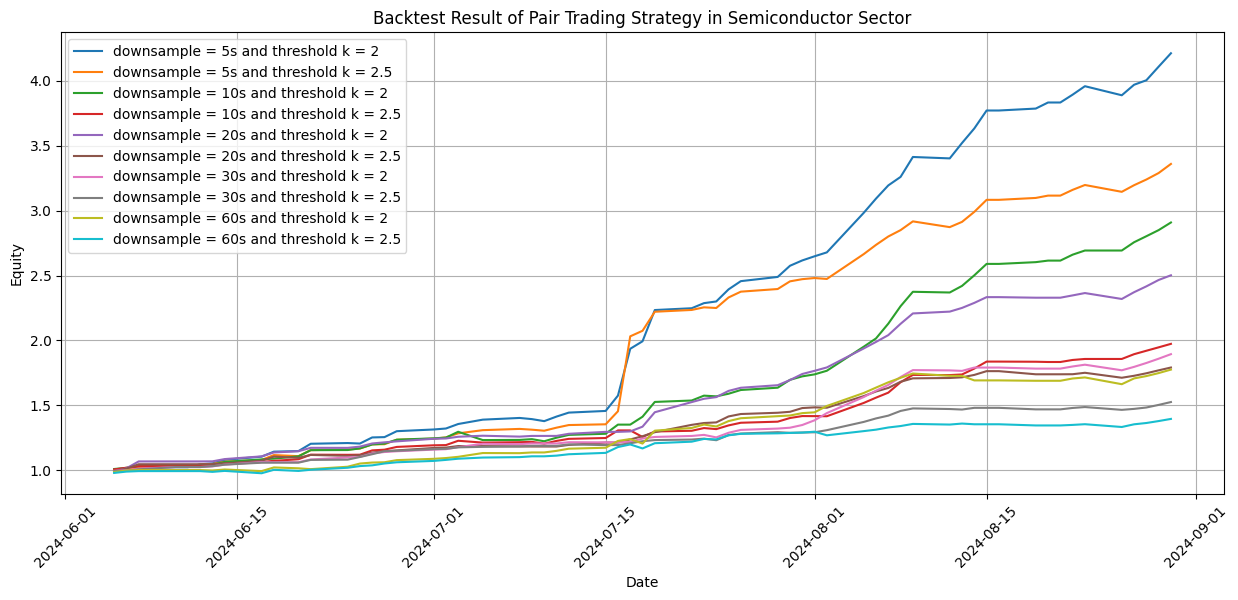

In [5]:
# symbols = ["SMH", "SOXX","NVDA", "TSM", "AMD", "ASML", "AMAT", "QCOM","INTC"]
# Initialize the comparison DataFrame properly
df_bt_parameter_comparison = pd.DataFrame(columns=["Downsample (s)", "Threshold - k", "Average Daily Return", 
                                                   "Volatility", "Sharpe Ratio", "VaR(95% of confidence)", 
                                                   "CVaR(95% of confidence)", "MDD", "Win-loss ratio"])

plt.figure(figsize = (15, 6))

for downsample in [5, 10, 20, 30, 60]:
    for threshold in [2, 2.5]:
        # Read the CSV file
        try:
            df_bt_result = pd.read_csv(f"backtest-result/bt_result_ds{downsample}_k{threshold}_no_repeat.csv", sep=";")
        except Exception as e:
            print(f"bt_result_ds{downsample}_k{threshold}_no_repeat.csv not found!")
            continue
         
        # Plot cumulative returns
        plt.plot(pd.to_datetime(df_bt_result["Trading Day"], format="%Y%m%d"), 
                 (1 + df_bt_result['return']).cumprod(), label=f"downsample = {downsample}s and threshold k = {threshold}")
        
        # Extract the return data
        daily_return_list = df_bt_result['return'].values
        
        # Calculate statistics
        mean_ret = daily_return_list.mean()
        vol = daily_return_list.std()
        sr = mean_ret / vol * np.sqrt(252)  # Sharpe Ratio
        
        # VaR at 95% confidence level using the historical method
        confidence_level = 0.95
        VaR = np.percentile(daily_return_list, (1-confidence_level) * 100)
        
        # CVaR at 95% confidence level
        CVaR = daily_return_list[daily_return_list <= VaR].mean()
        
        # Calculate maximum drawdown (MDD)
        cumulative_returns = np.cumprod(1 + daily_return_list)
        running_max = np.maximum.accumulate(cumulative_returns)
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = np.min(drawdown)
        
        # Calculate Win/Loss ratio
        win_loss_ratio = len(daily_return_list[daily_return_list > 0]) / len(daily_return_list[daily_return_list < 0])
        final_return = (1 + df_bt_result['return']).cumprod().iloc[-1]

        
        # Create a new row with the calculated metrics
        new_row = {
            "Downsample (s)": downsample,
            "Threshold - k": threshold,
            "Average Daily Return": mean_ret,
            "Volatility": vol,
            "Sharpe Ratio": sr,
            "VaR(95% of confidence)": VaR,
            "CVaR(95% of confidence)": CVaR,
            "MDD": max_drawdown,
            "Win-loss ratio": win_loss_ratio,
            "Final return": final_return
        }
        
        # Append the new row to the DataFrame using pd.concat
        df_bt_parameter_comparison = pd.concat([df_bt_parameter_comparison, pd.DataFrame([new_row])], ignore_index=True)

# Plot settings
plt.title("Backtest Result of Pair Trading Strategy in Semiconductor Sector")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Equity")
plt.legend()
plt.grid()
plt.show()


In [6]:
df_bt_parameter_comparison

,Downsample (s),Threshold - k,Average Daily Return,Volatility,Sharpe Ratio,VaR(95% of confidence),CVaR(95% of confidence),MDD,Win-loss ratio,Final return
0,5,2,0.024438,0.035958,10.788602,-0.006437,-0.011140,-0.017650,8.500000,4.211968
1,5,2.5,0.021156,0.051751,6.489693,-0.007326,-0.011748,-0.016443,6.125000,3.359601
2,10,2,0.017906,0.022683,12.531893,-0.002304,-0.017073,-0.056342,12.500000,2.908695
3,10,2.5,0.011341,0.016330,11.025121,-0.006049,-0.016871,-0.038569,4.400000,1.973932
4,20,2,0.015311,0.018366,13.233424,-0.001852,-0.008968,-0.019279,9.400000,2.501970
5,20,2.5,0.009696,0.013538,11.369419,-0.006382,-0.012600,-0.028835,4.777778,1.791676
6,30,2,0.010645,0.015328,11.024123,-0.004095,-0.011903,-0.023766,4.666667,1.894581
7,30,2.5,0.007002,0.010227,10.867952,-0.006294,-0.009623,-0.014523,5.375000,1.525744
8,60,2,0.009624,0.018487,8.263776,-0.013897,-0.023041,-0.047178,3.076923,1.775633
9,60,2.5,0.005553,0.011862,7.431299,-0.018248,-0.021355,-0.025663,3.818182,1.395903


### Key Observations:

A downsampling interval of 20 seconds with a Bollinger Band threshold \( k = 2 \) may offer a good overall balance between return, risk, and execution in real-world trading (considering slippage and order fulfillment).